In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

#### Đọc bộ dữ liệu

In [3]:
data_path = '../data/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']

In [4]:
print(X.shape, y.shape)

(300, 2) (300,)


In [5]:
X[:10]

array([[ 0.        ,  0.        ],
       [ 0.00096008,  0.01005528],
       [ 0.01045864,  0.01728405],
       [ 0.00087922,  0.03029027],
       [ 0.00991727,  0.03916803],
       [ 0.00677283,  0.05004887],
       [ 0.01419082,  0.05892126],
       [ 0.03115796,  0.06347182],
       [-0.00803244,  0.08040787],
       [ 0.04447445,  0.07928736]])

In [6]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

#### Chia bộ dữ liệu train/vale/test theo tỉ lệ 7:2:1


In [7]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=val_size, 
    shuffle=is_shuffle, 
    random_state=random_state
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, 
    test_size=test_size, 
    shuffle=is_shuffle, 
    random_state=random_state
)

#### Chuẩn hóa đặc trưng đầu vào

In [8]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False)
test_loader = DataLoader(test_dataset, 
                        batch_size=batch_size, 
                        shuffle=False)

#### Xây dựng mạng MLP


In [11]:
# Bài 9.3: chuyển hàm kích hoạt thành tanh
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.output(x)
        return x.squeeze(1)

In [12]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 128

model = MLP(input_dims=input_dims, 
            hidden_dims=hidden_dims, 
            output_dims=output_dims).to(device)

#### Khai báo hàm los và optimizer


In [13]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

#### Xây dựng hàm tính độ chính xác

In [14]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

#### Huấn luyện mô hình

In [15]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch+1}:\tTraining Loss: {train_loss:.3f}\tValidation Loss: {val_loss:.3f}')


EPOCH 1:	Training Loss: 0.887	Validation Loss: 0.874

EPOCH 2:	Training Loss: 0.741	Validation Loss: 0.856

EPOCH 3:	Training Loss: 0.733	Validation Loss: 0.860

EPOCH 4:	Training Loss: 0.727	Validation Loss: 0.864

EPOCH 5:	Training Loss: 0.723	Validation Loss: 0.878

EPOCH 6:	Training Loss: 0.714	Validation Loss: 0.861

EPOCH 7:	Training Loss: 0.720	Validation Loss: 0.844

EPOCH 8:	Training Loss: 0.702	Validation Loss: 0.835

EPOCH 9:	Training Loss: 0.718	Validation Loss: 0.829

EPOCH 10:	Training Loss: 0.719	Validation Loss: 0.815

EPOCH 11:	Training Loss: 0.692	Validation Loss: 0.841

EPOCH 12:	Training Loss: 0.727	Validation Loss: 0.829

EPOCH 13:	Training Loss: 0.692	Validation Loss: 0.813

EPOCH 14:	Training Loss: 0.676	Validation Loss: 0.800

EPOCH 15:	Training Loss: 0.660	Validation Loss: 0.816

EPOCH 16:	Training Loss: 0.688	Validation Loss: 0.798

EPOCH 17:	Training Loss: 0.670	Validation Loss: 0.786

EPOCH 18:	Training Loss: 0.665	Validation Loss: 0.790

EPOCH 19:	Training

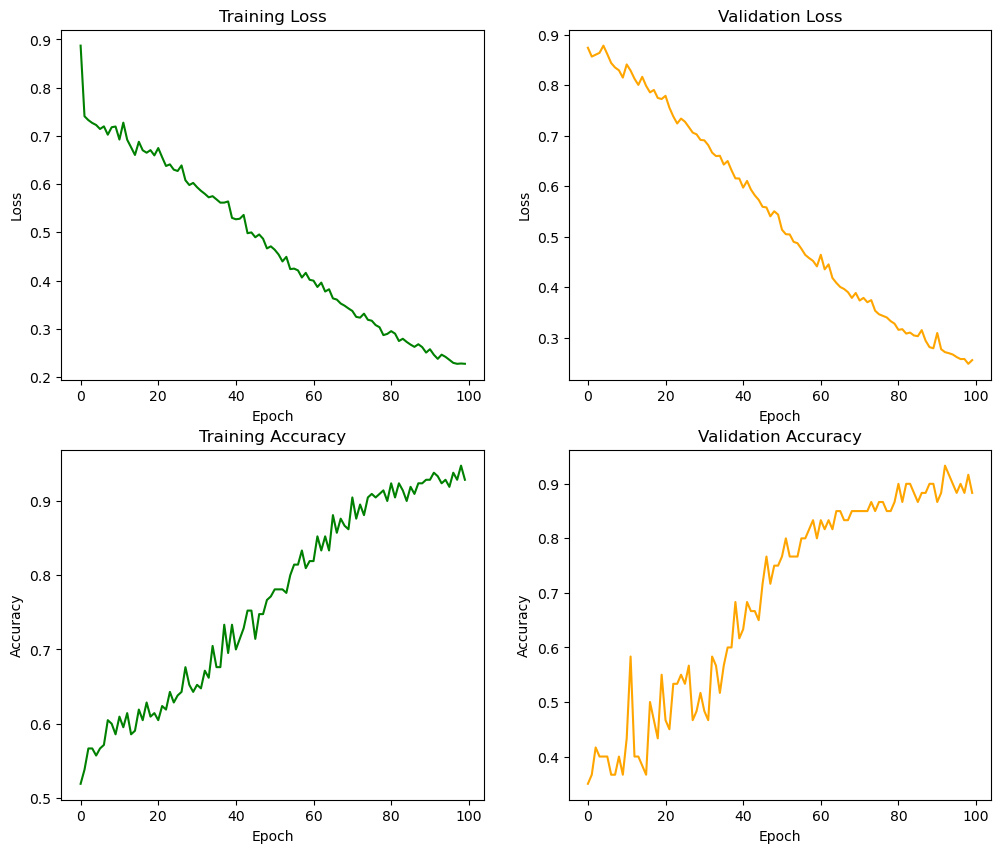

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

#### Đánh giá mô hình

In [17]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

test_predict = torch.cat(test_predict)
test_target = torch.cat(test_target)
test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9
